## Compartmentation and Clustering
- 

C:\Users\Julius\PycharmProjects\PPOD\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


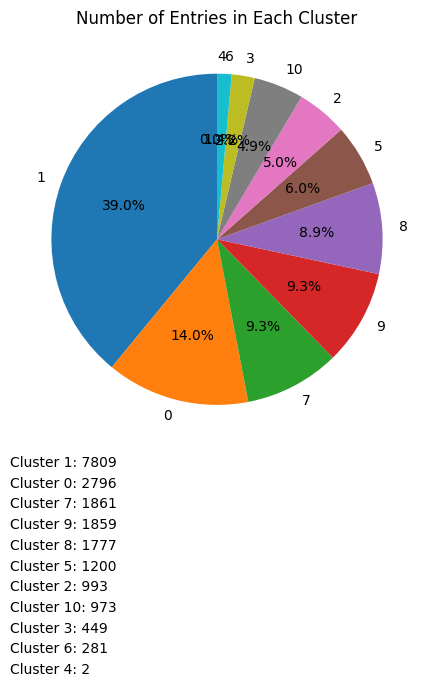

            age       weight     height         region
0     25.786156   173.048396  69.302195  South Central
1     42.011822   182.564213  70.099409     North East
2      0.000000     0.000000   0.000000     North East
3     33.508897    28.544484  71.241993         Europe
4     33.537196   175.891631  69.546495     North East
5     37.045833   225.484167  73.009167   Mid Atlantic
14    38.833837     0.418933   0.020141     North East
21    29.038731   206.584185  72.236686  North Central
28    29.100719     0.479959   0.007194         Europe
49    33.603563   185.505568   0.532294     North East
6157  33.500000  1994.000000  35.500000     North East


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
df = pd.read_csv('reduced_athletes.csv', low_memory=False)
df = df[df['name'] != "NA"]
# Identify sensitive columns that need to be anonymized
sensitive_columns = ['age', 'weight', 'height', 'region']
df.fillna(0, inplace=True)

# Feature scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[sensitive_columns[:-1]])  # Exclude 'region' from scaling

# Clustering
kmeans = KMeans(n_clusters=11)
clusters = kmeans.fit_predict(df_scaled)
df['cluster'] = clusters

for cluster in df['cluster'].unique():
    cluster_indices = df[df['cluster'] == cluster].index
    for column in sensitive_columns:
        if column != 'region':
            # Apply your anonymization technique here
            # For example, replace the actual values with the mean of the cluster
            df.loc[cluster_indices, column] = df.loc[cluster_indices, column].mean()
        else:
            # Find the most common non-zero, non-'NaN' value for 'region' in the current cluster
            mode_values = df.loc[cluster_indices, 'region'].replace([0, 'NaN', 'NA'], np.nan).mode()
            if not mode_values.empty:
                most_common_region = mode_values.iloc[0]
                df.loc[cluster_indices, 'region'] = most_common_region
            # Replace 'region' values in the current cluster with the most common value
            df.loc[cluster_indices, 'region'] = most_common_region

# Count the number of entries in each cluster
cluster_counts = df['cluster'].value_counts()

# Plot the counts in a pie chart
fig, ax = plt.subplots(figsize=(18, 18))
ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Number of Entries in Each Cluster')

# Display the count of each cluster below the pie chart
for i, (cluster, count) in enumerate(cluster_counts.items(), start=1):
    plt.annotate(f"Cluster {cluster}: {count}", xy=(0, -0.05*i), xycoords='axes fraction')

# Adjust the subplot parameters so that the subplot fits into the figure area
plt.subplots_adjust(bottom=0.1 + 0.05*len(cluster_counts))

# Show the plot
plt.show()



# Drop the cluster column if it's no longer needed
df.drop('cluster', axis=1, inplace=True)

# Save or return the anonymized dataset
df_unique = df[sensitive_columns].drop_duplicates()

# Display the unique rows
print(df_unique)
df.to_csv('cluster.csv', index=False)

